# Movie Studio Analysis: Identifying Key Factors for Success in the Film Industry
## Background
The movie studio industry faces increasing pressure to maximize efficiency, minimize costs, and improve profitability while remaining competitive in an ever-changing market. With the growing complexity of film production, distribution, and marketing, studios must leverage data-driven insights to make informed decisions and stay ahead of industry trends. The project involves researching current box office trends to identify film genres, themes, and styles that are resonating most with audiences. This data-driven analysis will highlight popular film characteristics and emerging viewer preferences, offering valuable insights on what types of movies are achieving commercial success.

## Problem Statement
This problem revolves around understanding and improving the operational performance of movie studios using data analytics. The goal is to identify inefficiencies, optimize production pipelines, and propose actionable recommendations to enhance overall business performance.
We were charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

## Objectives

1. Analyze the trend in movie sales over time to identify shifts in audience demand.
2. Identify key market segments to target for maximum engagement and revenue generation.
3. Assess the popularity of different film genres to guide genre selection in alignment with audience preferences.
4. Evaluate the impact of movie runtime on popularity to determine optimal lengths for future productions.

## Data cleaning and preparation

In [1]:
# Importing all the libraries to be used in our analysis
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import zipfile
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Loading the data from .csv zipped
with zipfile.ZipFile("./DATA/bom.movie_gross.zip","r") as z:
    with z.open("bom.movie_gross.csv") as f:
        df1 = pd.read_csv(f)
df1.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
# droppinng null values and adjusting the data types
df1.dropna(inplace = True)
df1['foreign_gross'] = df1['foreign_gross'].str.replace(',','').astype('float')

In [4]:
# getting to understand what is contained in the dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   float64
 4   year            2007 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 94.1+ KB


In [5]:
#descriptive statistics of the data
df1.describe()

,domestic_gross,foreign_gross,year
count,2.007000e+03,2.007000e+03,2007.000000
mean,4.701984e+07,7.579038e+07,2013.506228
std,8.162689e+07,1.381796e+08,2.597997
min,4.000000e+02,6.000000e+02,2010.000000
25%,6.700000e+05,3.900000e+06,2011.000000
50%,1.670000e+07,1.940000e+07,2013.000000
75%,5.605000e+07,7.595000e+07,2016.000000
max,9.367000e+08,9.605000e+08,2018.000000


The data is made up five columns.

- The **title** column containes the titles of the movies produced by different studios
- The **studio** column contains the names of the studio which produced differnt movies
- The **domestic_gross** column has the amount realized for selling a movie in the domestic market
- The **foreign_gross** column has the amount realized for selling a movie in the foreign market
- The **year** column shows the year in which the movie was produced

In [6]:
# create a new column that has the total sales for a movie
df1['combined_gross'] = df1['domestic_gross'] + df1['foreign_gross']

In [7]:
# loading the second dataset to be used
with zipfile.ZipFile('./DATA/im.db.zip', 'r') as z:
    z.extract('im.db',"./To_ignore")

In [8]:
# creating a connection to the database
conn = sqlite3.connect("./To_ignore/im.db")

In [9]:
# To view the tables in our database
pd.read_sql('''
            SELECT name FROM sqlite_master
            WHERE type = 'table'
            ''',conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


The tables contained in our database are 8 but we will only utilize 3 for this analysis, that is, movie_ratings, movie_akas, and movie_basics. 

In [10]:
# Selecting the tables to be used in this research
query = '''SELECT title,runtime_minutes,
            genres,averagerating AS rating,
            numvotes
            FROM movie_basics
            LEFT JOIN movie_ratings
            USING(movie_id)
            LEFT JOIN movie_akas
            USING(movie_id)
            WHERE runtime_minutes < 1500
            '''
df2 = pd.read_sql(query,conn)
df2.head()

,title,runtime_minutes,genres,rating,numvotes
0,Sangharsh,175.0,"Action,Crime,Drama",7.0,77.0
1,Sungharsh,175.0,"Action,Crime,Drama",7.0,77.0
2,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0
3,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0
4,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0


In [11]:
# To drop the null values and see more information about the data
df2.dropna(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249717 entries, 0 to 314172
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   title            249717 non-null  object 
 1   runtime_minutes  249717 non-null  float64
 2   genres           249717 non-null  object 
 3   rating           249717 non-null  float64
 4   numvotes         249717 non-null  float64
dtypes: float64(3), object(2)
memory usage: 11.4+ MB


In [12]:
# To get the descriptive statistics of the second dataset
df2.describe()

,runtime_minutes,rating,numvotes
count,249717.000000,249717.000000,2.497170e+05
mean,99.262341,6.270072,3.017144e+04
std,22.247894,1.241242,9.678438e+04
min,3.000000,1.000000,5.000000e+00
25%,87.000000,5.600000,8.100000e+01
50%,96.000000,6.400000,7.650000e+02
75%,110.000000,7.100000,8.751000e+03
max,1440.000000,10.000000,1.841066e+06


The second dataset contains 5 columns.
- **title** column with the title of the movies
- **runtime_minutes** column with the time each movie takes to watch
- **genres** column with the genre of the movie
- **rating** column with the rating of the movie
- **numvotes** column has the number of votes for each movie

## Exploratory Data Analysis (EDA)

To understand the trend of the sales overtime, we make a line plot.

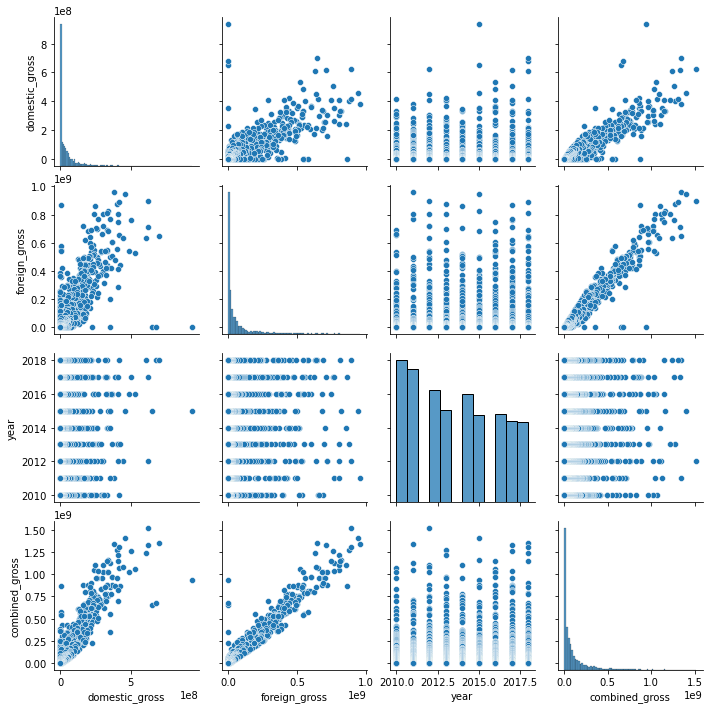

In [13]:
#  Run a pairplot to get an understanding of the correlation in the data
sns.pairplot(df1);

There is a strong positive correlation between foreign gross and domestic gross, foreign gross and combined_gross and domestic gross and combined gross

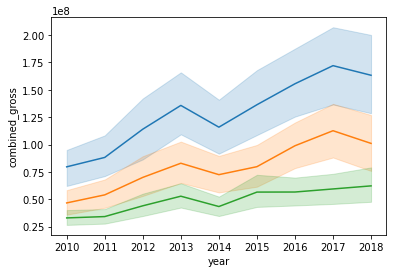

In [14]:
# Construction of a line plot using seaborn
fig, ax = plt.subplots()
sns.lineplot(x = df1['year'],y = df1['combined_gross'])
sns.lineplot(x = df1['year'],y = df1['foreign_gross'])
sns.lineplot(x = df1['year'],y = df1['domestic_gross']);

**Recommendation 1:** As shown in the above diagram, there has been an increase in the sales of the movies overtime indicating that the industry's demand has been on the rise, therefore this venture is viable for the company and could definately be explored.

We have to then understand the difference in the domestic market and the foreign markets and whether there is a need to focus on one to improve on the profits.

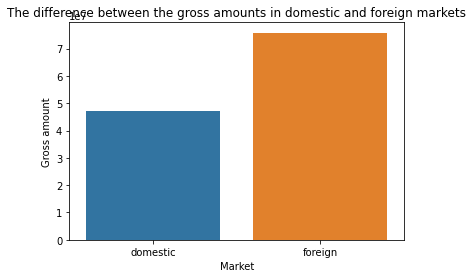

In [15]:
# A plot to show the difference between the domestic market and the foreign market
x = ['domestic','foreign']
y = [df1['domestic_gross'].mean(),df1['foreign_gross'].mean()]
fig, ax = plt.subplots()
sns.barplot(x=x,y=y)
ax.set_title("The difference between the gross amounts in domestic and foreign markets")
ax.set_ylabel("Gross amount")
ax.set_xlabel("Market");

From the bar plot above there is a difference in the amounts gained in the foreign market and in the domestic market. The foreign market has more returns than the domestic market. This could be attributed to the size of the two markets. 

**Recommendation 2:** The company should focus on maximizing on the foreign market sales.

To get a better understanding of how to be successful in this industry the company could benchmark from the top performing studios and get to understand what it is they do to set themselves apart.

In [16]:
studio = df1.groupby(['studio'])[['combined_gross','domestic_gross','foreign_gross']].mean().sort_values('combined_gross',ascending = False)
studio.head()

,combined_gross,domestic_gross,foreign_gross
studio,,,
HC,8.703000e+08,2.700000e+06,8.676000e+08
P/DW,5.076500e+08,1.682900e+08,3.393600e+08
BV,4.249075e+08,1.768897e+08,2.480178e+08
GrtIndia,2.542000e+08,2.020000e+07,2.340000e+08
WB,2.368577e+08,9.325846e+07,1.435993e+08


The table above shows the most profitable studios with HC being at the top. The company should therefore, benchmark and try to adopt practices that these top studios do to achieve the numbers that they have over the years.

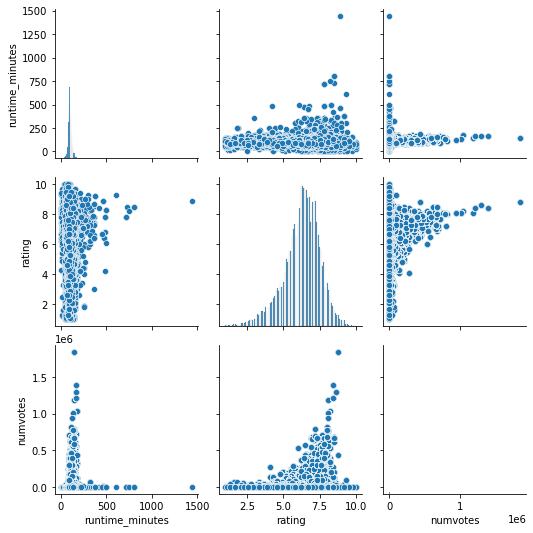

In [17]:
sns.pairplot(df2);

There appears to be no/minimal correlation in the factors in the second data set. We could further confirm that the runtime of movies does not affect its popularity.

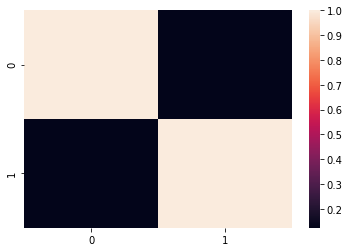

In [18]:
# heatmap of the correlation
corr = np.corrcoef(df2['runtime_minutes'],df2['rating'])
sns.heatmap(corr);

The above heatmap confirms that the runtime does not affect the popularity and thus the company's studio should not focus on the runtime but other factors of quality that will make the movies more popular. 
The genre of the movie is however anticipated to affect the popularity of the movie.

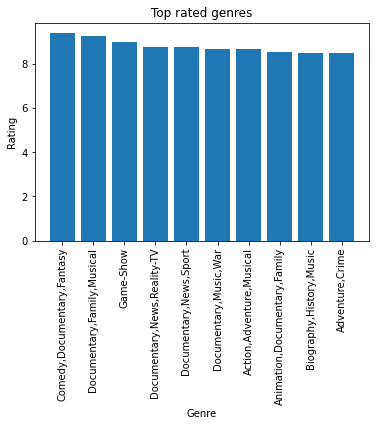

In [19]:
# assigning an average rating to different genres
genre = df2.groupby(['genres'])['rating'].mean().sort_values(ascending = False)

#plotting the top ten genres
plt.bar(genre.index[:10],genre[:10])
plt.xticks(rotation = 90)
plt.title("Top rated genres")
plt.xlabel("Genre")
plt.ylabel("Rating");

Investing in the above genres will definitely have better returns owing to their superior popularity. 

**Recommendation 3:** The Comedy, Documentary, Fantasy genre is the most popular and therefore the studio should therefore venture into producing that genre.

## Statistical Analysis
1. Hypothesis Testing
There is a claim that there is a difference in the gross amount earned in the domestic and foreign market. To ascertain this we carried out a two sample independent t test.

**Null Hypothesis ($H_0$):** There is no difference in the gross amount earned in the domestic market compared to that earned in the foreign market. $\mu_1$ = $\mu_2$

**Alternative Hypothesis ($H_1$):** There is a difference in the gross amount earned in the domestic market compared to that earned in the foreign market. $\mu_1$ $\neq$ $\mu_2$

In [20]:
# Sample means
Domestic_market_mean = df1['domestic_gross'].mean()
Foreign_market_mean = df1['foreign_gross'].mean()
# Sample STDs
Domestic_market_std = df1['domestic_gross'].std()
Foreign_market_std = df1['foreign_gross'].std()

print(f'''The average gross earnings for a movie in the domestic market is {Domestic_market_mean},
with a standard deviation of {Domestic_market_std}, while the average earnings in the foreign market
is {Foreign_market_mean} with a standard deviation of {Foreign_market_std}. The question is, is there a difference?
And if so, is it statistically significant?''')

The average gross earnings for a movie in the domestic market is 47019840.20179372,
with a standard deviation of 81626889.32323603, while the average earnings in the foreign market
is 75790384.84130543 with a standard deviation of 138179552.62752098. The question is, is there a difference?
And if so, is it statistically significant?


In [21]:
# conducting a two tailed T-test to compare the two columns, foreign & domestic

# Perform independent two-sample t-test
t_statistic, p_value = stats.ttest_ind(df1['domestic_gross'], df1['foreign_gross'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Check if p-value is less than 0.05 (significance level)
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between domestic and foreign gross sales.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between domestic and foreign gross sales.")

T-statistic: -8.031155356380022
P-value: 1.2578338636090253e-15
Reject the null hypothesis: There is a significant difference between domestic and foreign gross sales.


The hypothesis test confirms that the earlier difference between the gross amount earned in the foreign market and domestic market is significant and **recommendation 2** is affirmed. 

2. Test for normality

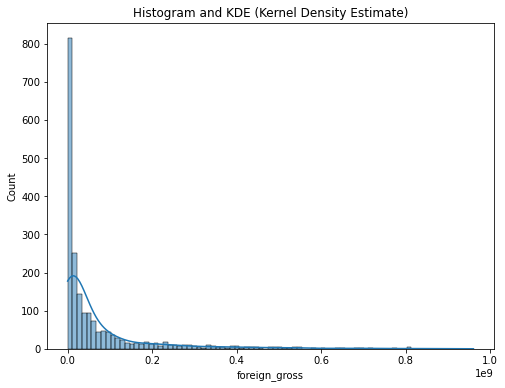

In [22]:
# to test for normality in foreign gross
# Plotting the histogram
plt.subplots(figsize=(8, 6))
sns.histplot(df1['foreign_gross'], kde=True)
plt.title("Histogram and KDE (Kernel Density Estimate)");

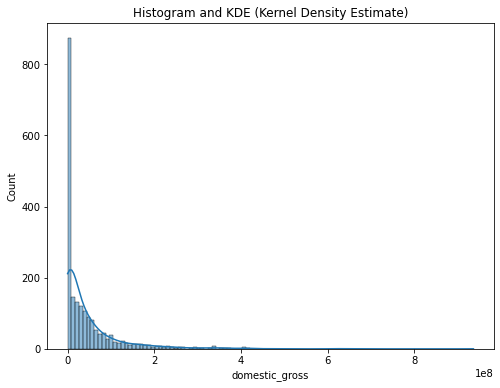

In [23]:
# to test for normality in domestic gross
# Plotting the histogram
plt.figure(figsize=(8, 6))
sns.histplot(df1['domestic_gross'], kde=True)
plt.title("Histogram and KDE (Kernel Density Estimate)");

## Regression Model

In [24]:
model = sm.OLS(endog = df1['foreign_gross'], exog = sm.add_constant(df1['domestic_gross']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     2882.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        05:24:05   Log-Likelihood:                -39573.
No. Observations:                2007   AIC:                         7.915e+04
Df Residuals:                    2005   BIC:                         7.916e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.467e+07   2.28e+06      6.431      0.000    1.02e+07    1.91e+07
domestic_gross     1.3000      0.024     53.682      0.000       1.252       1.347
==============================================================================
Omnibus:                      657.742   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124753.923
Skew:                          -0.242   Prob(JB):                         0.00
Kurtosis:                      41.621   Cond. No.                     1.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model has a coefficient of determination of 59% indicating that the 59% of the variation in the foreign gross is explained by variation in the domestic gross.

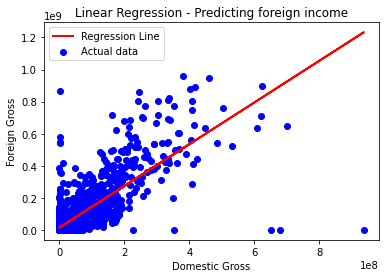

In [25]:
# Plot the data and the regression line
plt.scatter(df1['domestic_gross'],df1['foreign_gross'], color='blue', label='Actual data')  # Actual data points
plt.plot(df1['domestic_gross'],results.predict(), color='red', linewidth=2, label='Regression Line')  # Predicted line
plt.xlabel('Domestic Gross')
plt.ylabel('Foreign Gross')
plt.title('Linear Regression - Predicting foreign income')
plt.legend();

## Conclusion
The research done and the results found indicate that the company's plan of starting a movie studio is a viable venture and should therefore be explored. To ensure that the venture is profitable the recommendations mentioned in the report should be taken into consideration. The industry is everchanging and constant research and always keeping up to date with changes in consumer preferences and the financial performance of the industry.